In [2]:
using SeisNoise, PyPlot, CUDA, Glob, HDF5, Combinatorics, Random, Statistics, ImageFiltering, FFTW, JLD2, Dates
using CSV,DataFrames,SineFit,DSP,Interpolations
import SeisNoise: NoiseData
import SeisBase: read_nodal, NodalData, InstrumentPosition, InstrumentResponse, 
       show_str, show_t, show_x, show_os, timestamp
import FFTW: rfft, irfft
import Base:show, size, summary
import DSP
include("correlation/functions/Types.jl")
include("correlation/functions/Nodal.jl")
include("correlation/functions/Misc.jl")

apply_fk_l_geo (generic function with 1 method)

In [3]:
# list all 1khz and resampled Greenland files
path_1khz = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/"
path_resampled = "/1-fnp/pnwstore1/p-wd05/greenland/data/resampled"
files_1khz = glob("1kHz/*",path_1khz)
files_resampled = glob("*",path_resampled)
files = cat(files_1khz,files_resampled,dims=1)
N = read_nodal("segy", files[2])

# choose channels
chan_start = 331
chan_end = 1361
chans = [chan_start,chan_end]

# set filter band
freqmin,freqmax = 1,100
fs = freqmax*2+1

# set out path
out_path = "/fd1/solinger/rms/"

"/fd1/solinger/rms/"

In [ ]:
# carry out running rms computation
rms = compute_rms(files[2265:end],freqmin,freqmax,fs,chans,out_path,30000,500)

In [4]:
# read rms results
rms_mat = JLD2.load(out_path*"rms.jld2")["rms"]
t_das = JLD2.load(out_path*"t.jld2")["t"]

# filter out high frequencies
responsetype = DSP.Filters.Lowpass(0.0001; fs=1/30)
designmethod = DSP.Filters.Butterworth(4)
rms_filt = DSP.Filters.filt(DSP.Filters.digitalfilter(responsetype, designmethod), rms_mat')'

1031×6628 adjoint(::Matrix{Float64}) with eltype Float64:
 1.03107e-7  9.27923e-7  4.91415e-6  …  12.8578   12.8682   12.8792
 9.49586e-8  8.51363e-7  4.4973e-6      12.6994   12.7125   12.7261
 7.95876e-8  7.15977e-7  3.75629e-6     12.4224   12.4358   12.4496
 7.71559e-8  6.95551e-7  3.63117e-6     12.3669   12.3762   12.3859
 7.34354e-8  6.67807e-7  3.47557e-6     11.8615   11.8649   11.8686
 7.33966e-8  6.55813e-7  3.32184e-6  …  11.0615   11.0644   11.0675
 8.39041e-8  7.34709e-7  3.56687e-6     10.5585   10.5617   10.5652
 8.31937e-8  7.26287e-7  3.48227e-6      9.92336   9.92619   9.92925
 8.76548e-8  7.62952e-7  3.60178e-6      9.73504   9.73615   9.73747
 6.27647e-8  5.53945e-7  2.68464e-6      9.60714   9.60897   9.61101
 6.38311e-8  5.63647e-7  2.71418e-6  …   9.44573   9.44913   9.45276
 6.17415e-8  5.51047e-7  2.65748e-6      9.59247   9.59611   9.5999
 6.29033e-8  5.58363e-7  2.65166e-6      9.0877    9.09322   9.09891
 ⋮                                   ⋱   ⋮           

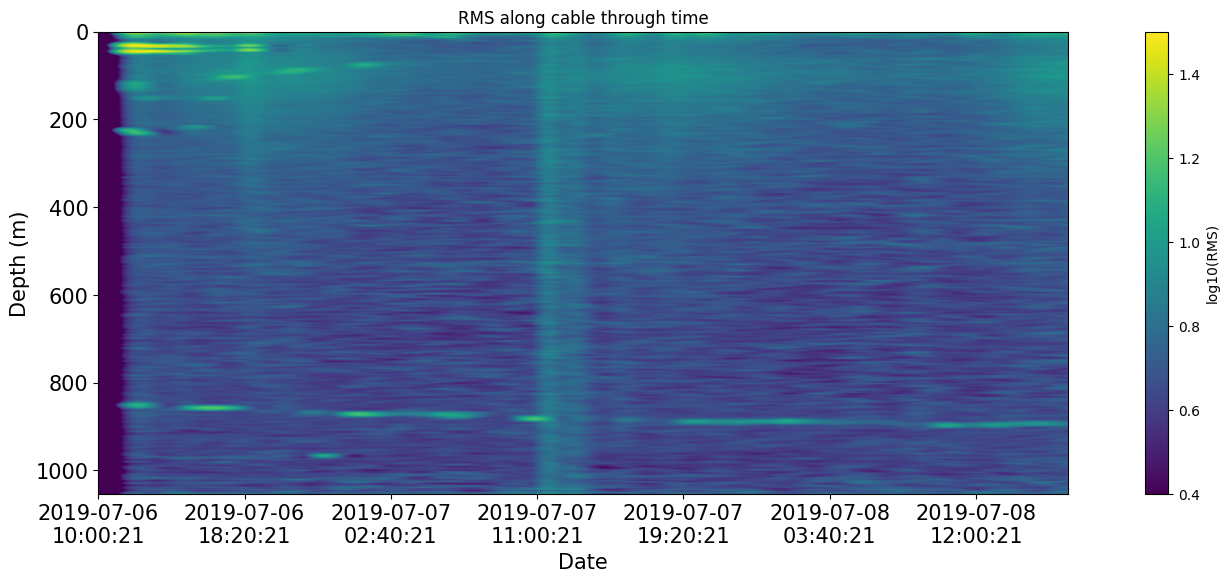

PyObject Text(0.5, 1.0, 'RMS along cable through time')

In [6]:
plt.figure(figsize=(20,6))
spacing = (N.misc[4]["shot_point"]-N.misc[3]["shot_point"])/1000
bottom = size(rms_filt,1)*spacing
plt.imshow(log.(10,rms_filt),vmin=0.4,vmax=1.5,aspect=3,extent=(1,size(rms_filt,2),bottom,0))
plt.colorbar(label="log10(RMS)")
xtick_loc = range(1,size(rms_filt,2),step = 1000)
xtick_dates = t_das[range(1,size(rms_filt,2),step = 1000)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_loc,xtick_labels,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Depth (m)",fontsize=15)
plt.title("RMS along cable through time")
#plt.savefig("figures/rms_fig.png")

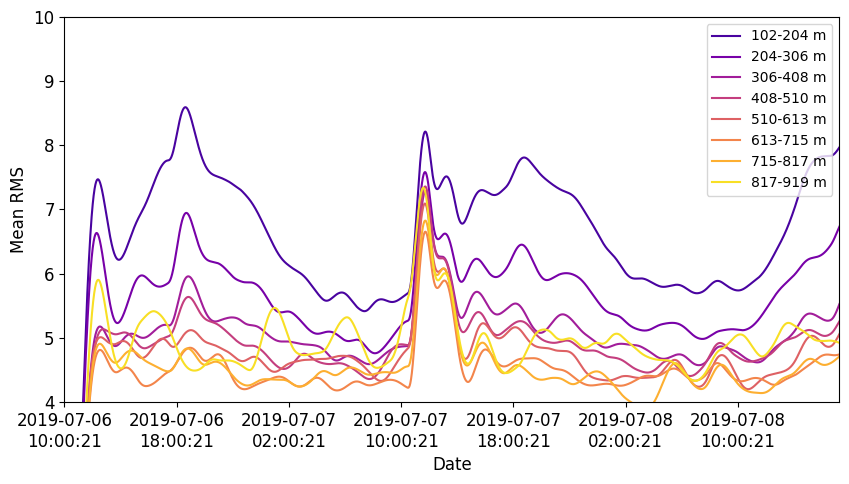

PyObject Text(28.000000000000007, 0.5, 'Mean RMS')

In [12]:
# make plots of near-surface diurnal rms (show decay through depth)
interval = 100
start = 1
fig,ax = plt.subplots(figsize=(10,5))
cmap = plt.cm.plasma
cmaplist = [cmap(i) for i in range(1,cmap.N)]
j = 1
for i in range(100,830,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax.plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*30])
    j += 1
end
plt.legend()
xtick_dates = t_das[range(start,size(rms_filt,2),step = 960)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,xtick_labels,fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim(4,10)
ax.set_xlim(t_das[start],t_das[end])
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Mean RMS",fontsize=12)

In [ ]:
# choose channel and duration
chans = [1330,1340]
sec_per_file = 30
#duration = 864000
#num_files = duration/sec_per_file
num_files = size(files,1)
start_file = 2

# read file in the "good" part of the data
trace = Float64[]
for i = 1:num_files
    N = read_nodal("segy", files[Int64(start_file+i)])
    data = N.data[:,chans[1]:chans[2]]
    stack = sum(data,dims=2)./size(data,2)
    trace = cat(trace,stack,dims=1)
end

# save trace
JLD2.save("/1-fnp/pnwstore1/p-wd05/greenland/misc/chan_"*string(chans[1])*"-"*string(chans[2])*"_combined_trace.jld2", "trace", trace)

In [ ]:
# read water pressure
p_BH19c = DataFrame(CSV.File("borehole_data/BH19c_pressure.csv"))
format = "yyyy-mm-dd HH:MM:SS"
t_BH19c =  [DateTime(p_BH19c[i,1],format) for i in range(1,size(p_BH19c,1))]

# read BH19e pressure and ice velocity
p_BH19e = DataFrame(CSV.File("borehole_data/BH19e_pressure.csv"))
t_BH19e =  [DateTime(p_BH19e[i,1],format) for i in range(1,size(p_BH19e,1))]
gnss = DataFrame(CSV.File("borehole_data/R30_GNSS.csv"))
t_gnss = [DateTime(gnss[i,1],format) for i in range(1,size(gnss,1))]

# extract part that corresponds to the DAS deployment
format = dateformat"y-m-d H:M:S"
before_end = [DateTime(p_BH19c[i,1],format) .< t_das[end] for i in range(1,size(p_BH19c,1))]
after_start = [DateTime(p_BH19c[i,1],format) .> t_das[1] for i in range(1,size(p_BH19c,1))]
in_window = [before_end.+after_start .== 2][1]
p_BH19c_during_DAS = p_BH19c[in_window,:]
t_BH19c_during_DAS =  [DateTime(p_BH19c_during_DAS[i,1],format) for i in range(1,size(p_BH19c_during_DAS,1))]

In [ ]:
# read combined trace
trace = JLD2.load("/1-fnp/pnwstore1/p-wd05/greenland/misc/chan_1330-1340_combined_trace.jld2")["trace"]

# set window size in seconds
win_size = 2000

# make spectrogram
fs = N.fs[1]
spec = DSP.Periodograms.spectrogram(trace[:,1], Int64(win_size*fs), round(Int64,0.95*win_size*N.fs[1]),fs=fs)

# get time axis
spec_time = [t_das[1]+Second(st) for st in spec.time]

In [ ]:
# plot spectrogram
fig,ax = plt.subplots(2,1,figsize=(10,7),gridspec_kw=Dict("height_ratios" => [1,2]))
ax[2].imshow(reverse(log.(10,spec.power),dims=1),extent=(spec.time[1],spec.time[end],spec.freq[2],spec.freq[end]),aspect="auto",vmin=-1,vmax=0.75)
xtick_loc = spec.time[range(1,size(spec.time,1),step = 1000)]
xtick_dates = spec_time[range(1,size(spec.time,1),step = 1000)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_loc,xtick_labels)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
ax[2].set_ylim(4e-3,10)
ax[2].set_yscale("log")

interval = 250
j = 1
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax[1].plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*60])
    j+=1
end
ax[1].legend(loc=3)
ax3 = ax[1].twinx()
#ax3.plot(t_borehole,p_during_DAS[:,3],label="Pressure",c="blue",linestyle="--",linewidth=3)
ax3.plot(t_BH19e.-Day(25).-Minute(40),p_BH19e[:,3],label="BH19e",c="red",linestyle="--",linewidth=4)
mean_p = Statistics.mean(p_BH19c_during_DAS[:,3])
flipped_p = mean_p .+ (p_BH19c_during_DAS[:,3].-mean_p)*-1
mean_vel = Statistics.mean(gnss[80:end,6])
ax3.plot(t_gnss[80:end].-Day(16),(gnss[80:end,6].-mean_vel)*0.05.+mean_vel.+223,label="Velocity",c="orange")
ax3.set_ylim(770,780)
xtick_dates = t_das[range(1,size(rms_filt,2),step = 960)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,[],fontsize=12)
plt.yticks(fontsize=12)
ax3.legend(loc=2)
ax[1].set_ylim(4,10)
ax[1].grid("major",axis="x")
ax3.set_xlim(t_das[1],t_das[end])
ax3.set_xlabel("Date",fontsize=12)
ax3.set_ylabel("Hydraulic head (m)",fontsize=12)
ax[1].set_ylabel("Mean RMS",fontsize=12)
plt.savefig("figures/pressure_rms_spec_vel.png",dpi=150)

In [ ]:
# plot a subset of the spectrogram
starttime = DateTime(2019,7,6,16)
endtime = DateTime(2019,7,6,22)
ind = intersect(findall(x->x > starttime, spec_time), findall(x->x < endtime, spec_time))

# set frequency band
freq = [0.001,0.01]

# plot spectrogram
fig,ax = plt.subplots(2,1,figsize=(10,7),gridspec_kw=Dict("height_ratios" => [1,2]))
ax[2].imshow(reverse(log.(10,spec.power),dims=1),extent=(spec.time[1],spec.time[end],spec.freq[2],spec.freq[end]),aspect="auto",vmin=-1,vmax=0.75)
xtick_loc = spec.time[range(1,size(spec.time,1),step = 100)]
xtick_dates = spec_time[range(1,size(spec.time,1),step = 100)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_loc,xtick_labels)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
ax[2].set_ylim(freq[1],freq[2])

interval = 250
j = 1
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax[1].plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*60])
    j+=1
end
ax[1].legend(loc=3)
ax3 = ax[1].twinx()
#ax3.plot(t_borehole,p_during_DAS[:,3],label="Pressure",c="blue",linestyle="--",linewidth=3)
ax3.plot(t_BH19e.-Day(25).-Minute(40),p_BH19e[:,3],label="BH19e",c="red",linestyle="--",linewidth=4)
mean_p = Statistics.mean(p_BH19c_during_DAS[:,3])
flipped_p = mean_p .+ (p_BH19c_during_DAS[:,3].-mean_p)*-1
mean_vel = Statistics.mean(gnss[80:end,6])
ax3.plot(t_gnss[80:end].-Day(16),(gnss[80:end,6].-mean_vel)*0.05.+mean_vel.+223,label="Velocity",c="orange")
ax3.set_ylim(770,780)
xtick_dates = t_das[range(1,size(rms_filt,2),step = 960)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,[],fontsize=12)
plt.yticks(fontsize=12)
ax3.legend(loc=2)
ax[1].set_ylim(4,10)
ax[1].grid("major",axis="x")
ax3.set_xlabel("Date",fontsize=12)
ax3.set_ylabel("Hydraulic head (m)",fontsize=12)
ax[1].set_ylabel("Mean RMS",fontsize=12)

# xlim
#ax[2].set_xlim(starttime,endtime)
ax3.set_xlim(starttime,endtime)
ax[2].set_xlim(spec.time[ind][1],spec.time[ind][end])
plt.savefig("figures/pressure_rms_spec_vel_"*string(freq[1])*"-"*string(freq[2])*"Hz_T16:00-22:00.png",dpi=150)

In [ ]:
# plot a subset of the spectrogram
starttime = DateTime(2019,7,5,13,17,20)
endtime = DateTime(2019,7,8,15)
ind = intersect(findall(x->x > starttime, spec_time), findall(x->x < endtime, spec_time))

# set frequency band
freq = [0.001,0.01]

# plot spectrogram
fig,ax = plt.subplots(1,1,figsize=(10,5))

interval = 250
j = 1
start = 2500
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax.plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*60])
    j+=1
end
ax.legend(loc=3)

ax3 = ax.twinx()
#ax3.plot(t_borehole,p_during_DAS[:,3],label="Pressure",c="blue",linestyle="--",linewidth=3)
ax3.plot(t_BH19e.-Day(25).-Minute(40),p_BH19e[:,3],label="Pressure (BH19e)",c="red",linestyle="--",linewidth=4)
mean_p = Statistics.mean(p_BH19c_during_DAS[:,3])
flipped_p = mean_p .+ (p_BH19c_during_DAS[:,3].-mean_p)*-1
mean_vel = Statistics.mean(gnss[80:end,6])
ax3.plot(t_gnss[80:end].-Day(16),(gnss[80:end,6].-mean_vel)*0.05.+mean_vel.+223,label="Velocity",c="orange")
ax3.set_ylim(770,780)
xtick_dates = t_das[range(1,size(rms_filt,2),step = 960*2)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,xtick_labels,fontsize=12)
plt.yticks(fontsize=12)
ax3.legend(loc=2)
ax.set_ylim(4,10)
ax.grid("major",axis="x")
ax3.set_xlabel("Date",fontsize=12)
ax3.set_ylabel("Hydraulic head (m)",fontsize=12)
ax.set_ylabel("Mean RMS",fontsize=12)

# xlim
#ax[2].set_xlim(starttime,endtime)
ax3.set_xlim(starttime,endtime)
plt.savefig("figures/pressure_rms_vel",dpi=150)

In [ ]:
# regress BH19c pressure, BH19e pressure, and ice velocity
p_BH19e = DataFrame(CSV.File("borehole_data/BH19e_pressure.csv"))
t_BH19e =  [DateTime(p_BH19e[i,1],format) for i in range(1,size(p_BH19e,1))]
gnss = DataFrame(CSV.File("borehole_data/R30_GNSS.csv"))
t_gnss = [DateTime(gnss[i,1],format) for i in range(1,size(gnss,1))]

# choose start and end times
reg_start = t_BH19e[7500]
reg_end = t_gnss[end]
reg_BH19e = p_BH19e[t_BH19e .> reg_start,:] 
reg_t_BH19e = t_BH19e[t_BH19e .> reg_start] 
reg_BH19c = p_BH19c[t_BH19c .> reg_start,:] 
reg_t_BH19c = t_BH19c[t_BH19c .> reg_start] 
reg_gnss = gnss[t_gnss .> reg_start,:]
reg_t_gnss = t_gnss[t_gnss .> reg_start]

# split borehole pressures where sample rate changes


# interpolate each part of both pressure curve

# put borehole pressures on same time axis as gnss

In [ ]:
# interpolate gnss get seconds since start time
itp_BH19c = interpolate(reg_BH19c[:,3], BSpline(Constant()))
itp_BH19e = interpolate(reg_BH19e[:,3], BSpline(Constant()))
itp_points_BH19c = range(1,size(reg_t_BH19c,1),step=size(reg_t_BH19c,1)/size(reg_t_gnss,1))
itp_points_BH19e = range(1,size(reg_t_BH19e,1),step=size(reg_t_BH19e,1)/size(reg_t_gnss,1))

In [ ]:
diffs = diff(diff(reg_t_BH19e))
diffs = [diffs[i].value for i in range(1,(size(diffs,1)))]
kink = findall(x -> x == sum(diffs),diffs)

In [ ]:
fig,ax1 = plt.subplots(figsize=(10,7))
ax1.plot(t_BH19e[7500:end],p_BH19e[7500:end,3],label="BH19e pressure",c="red",linestyle="--",linewidth=2)
ax1.plot(t_BH19c[500:end],p_BH19c[500:end,3],label="BH19c pressure",c="blue",linestyle="--",linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Hydraulic head (m)")
ax2 = ax1.twinx()
ax2.set_ylabel("Velocity (m/year)")
ax2.plot(t_gnss,gnss[:,6],c="orange",label="Velocity")
ax1.set_ylim(770,780)
ax2.set_ylim(350,630)
ax1.set_xlim(t_BH19c[5000],t_BH19c[end])
ax1.vlines((t_das[1],t_das[end]),770,790,linestyle="-",colors="k")
ax1.legend(loc=2)
ax2.legend(loc=1)
date_plot_fmt=matplotlib.dates.DateFormatter("%m-%d")
ax1.xaxis.set_major_formatter(date_plot_fmt)
plt.savefig("figures/pressure_and_velocity_zoom.png",dpi=150)

In [ ]:
# plot water pressure and surface noise rms
interval = 250
start = 2500
fig,ax = plt.subplots(figsize=(10,5))
cmap = plt.cm.plasma  # define the colormap
cmaplist = [cmap(i) for i in range(1,cmap.N)]
j = 1
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax.plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*60])
    j+=1
end
plt.legend()
ax1 = ax.twinx()
ax1.plot(t_BH19e.-Day(25).-Minute(40),p_BH19e[:,3],label="BH19e",c="red",linestyle="--",linewidth=4)
ax1.plot(t_BH19c_during_DAS,p_BH19c_during_DAS[:,3],c="blue",label="BH19c",linestyle="--",linewidth=4)
ax.legend(loc=3)
ax1.legend(loc=1)
ax1.set_ylim(760,780)
xtick_dates = t_das[range(start,size(rms_filt,2),step = 960)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,xtick_labels,fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim(4,12)
ax.set_xlim(t_das[start],t_das[end])
ax.set_xlabel("Date",fontsize=12)
ax1.set_ylabel("Hydraulic head (m)",fontsize=12)
ax.set_ylabel("Mean RMS",fontsize=12)
plt.show()
plt.savefig("figures/surface_noise_pressure_both",dpi=120)

In [ ]:
# do rms <0.25 Hz

# do rms on (0.01-0.1) and (0.0001-0.01). Requires sticking files together

In [ ]:
# read data
trace = JLD2.load("/fd1/solinger/chan_1330-1340_combined_trace.jld2")["trace"]

# get time values for our trace 
N = read_nodal("segy", files[2])
t_trace = [t_das[1]+Millisecond(dt) for dt in range(1,size(trace,1))]

In [ ]:
# isolate the time period we want
win_start = DateTime(2019,7,6,16,32,40)
win_end = win_start + Second(10)
window_ind1 = [t .> win_start]
window_ind2 = [t .< win_end]
window_ind = window_ind1 + window_ind2
window_ind = [window_ind[1] .== 2]

# filter the trace
freq = [10,25]
responsetype = DSP.Filters.Bandpass(freq[1],freq[2]; fs=1000)
designmethod = DSP.Filters.Butterworth(4)
trace_filt = DSP.Filters.filt(DSP.Filters.digitalfilter(responsetype, designmethod), trace[window_ind[1]])

# plot the filtered trace
plt.plot(t[window_ind[1]],trace_filt)

# plot 0.001, 1-10, 10-100z at July 7 0:00

